In [ ]:
# DATA PREP

Loading Jarir dataset...
Original columns: ['Showroom', 'GL Class', 'Classification Description', 'ItemDescription', 'ShortItemNo', 'Model', 'Vendor Prefix', 'Brand', 'ItemNumber', 'Date', 'SalesChannel', 'CustomerId', 'Customer_VAT_Status', 'UNQTRN', 'Sales Quantity 2024', 'No of Trans 2024', 'Sales Amount 2024']
Original data shape: (3001, 17)
Columns after renaming: ['country', 'category', 'Classification Description', 'description', 'short_item_no', 'model', 'vendor', 'brand', 'stock_code', 'invoice_date', 'sales_channel', 'customer_id', 'vat_status', 'unique_transaction', 'quantity', 'num_transactions', 'line_amount']
Fixing date parsing for Jarir...
Original date sample: 0    Jan-1
1    Jan-1
2    Jan-1
3    Jan-1
4    Jan-2
Name: invoice_date, dtype: object
Original date dtype: object
Parsed dates sample: 0   2024-01-01
1   2024-01-01
2   2024-01-01
3   2024-01-01
4   2024-01-02
Name: invoice_date, dtype: datetime64[ns]
Valid dates: 3001
Loaded rows: 3001
✅ Saved cleaned tables 

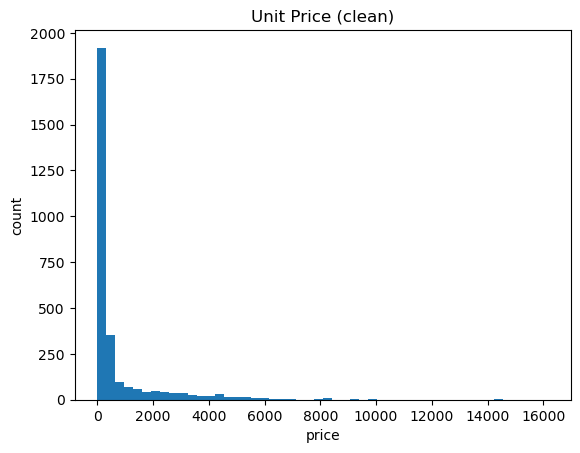

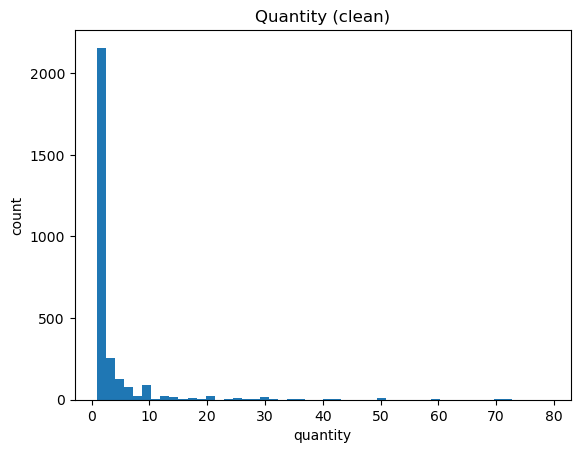

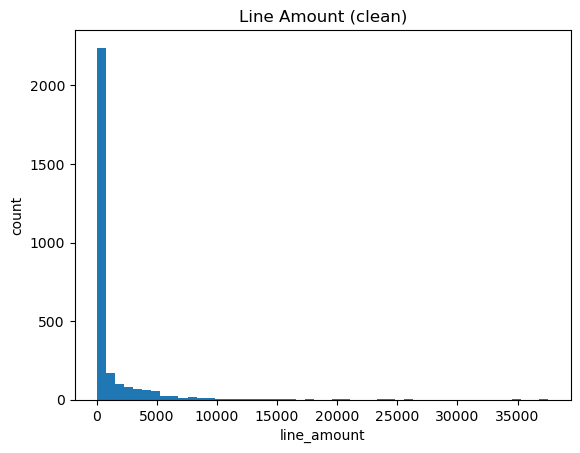

✅ Sequences saved: 1108 train | 169 val | 160 test
Time cuts: 2024-01-01 00:00:00 → 2024-10-14 00:00:00 → 2024-11-21 00:00:00 → 2024-12-31 00:00:00


,customer_id,user_idx,ts,history_idx,pos_item_idx,country
0,10018322,1,2024-03-07,66 76,1120,0103-PLAZA
1,10018322,1,2024-03-24,66 76 1120,1041,0103-PLAZA
2,10018322,1,2024-04-30,66 76 1120 1041,317,0103-PLAZA


item_id_map.parquet -> exists=True size=28975
customer_id_map.parquet -> exists=True size=12834
sequences_train.parquet -> exists=True size=26594
sequences_val.parquet -> exists=True size=8181
sequences_test.parquet -> exists=True size=8182
(1108, 6)
   customer_id  user_idx         ts      history_idx  pos_item_idx     country
0     10018322         1 2024-03-07            66 76          1120  0103-PLAZA
1     10018322         1 2024-03-24       66 76 1120          1041  0103-PLAZA
2     10018322         1 2024-04-30  66 76 1120 1041           317  0103-PLAZA


1735

In [1]:
# --- Config
from pathlib import Path
import pandas as pd
import numpy as np
import unicodedata, re, json
from datetime import datetime

DATA_PATH = Path('../data/raw/jarir.xlsx')   # Jarir dataset
OUT_DIR = Path('../data/processed/jarir/')  # Jarir output directory
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Cleaning toggles / thresholds
KEEP_ONLY_POSITIVE_QTY = True
KEEP_ONLY_POSITIVE_PRICE = True
DROP_RETURNS_BY_INVOICE_PREFIX = True   # transactions starting with 'C'
DROP_DUPLICATE_ROWS = True

# Non-product removal rules (description patterns; case-insensitive)
NON_PRODUCT_PATTERNS = [
    r'POSTAGE', r'SHIPPING', r'CARRIAGE', r'DELIVERY',
    r'BANK CHARGES', r'AMAZON', r'DOTCOM', r'PACKING', r'ADJUST', r'DISCOUNT',
    r'SAMPLE', r'SAMPLES', r'CHECK', r'TEST', r'MANUAL', r'FEE', r'CHARGE'
]

# Outlier handling (IQR on log values)
HANDLE_OUTLIERS = True
WINSORIZE_INSTEAD_OF_DROP = False   # if False, drop; if True, cap to bounds
LOG_EPS = 1e-6
IQR_MULT = 3.0     # 3*IQR is conservative on log scale

# Coverage filters (optional; applied after core cleaning)
MIN_EVENTS_PER_USER = 1       # set 1 to keep all users
MIN_PURCHASES_PER_ITEM = 1    # set 1 to keep all items

# Randomness
SEED = 42
np.random.seed(SEED)

# --- Load Excel file
print("Loading Jarir dataset...")
raw = pd.read_excel(DATA_PATH, engine='openpyxl')

print("Original columns:", raw.columns.tolist())
print("Original data shape:", raw.shape)

# --- Date parsing function for Jarir format ---
def parse_jarir_dates(date_series):
    """
    Parse Jarir dates like 'Jan-1', 'Jan-2', etc.
    Returns datetime series with 2024 as the year.
    """
    def parse_single_date(date_str):
        if pd.isna(date_str):
            return pd.NaT
        
        try:
            # Handle formats like 'Jan-1', 'Jan-2', etc.
            if isinstance(date_str, str) and '-' in date_str:
                month_day = date_str.split('-')
                if len(month_day) == 2:
                    month_str = month_day[0].strip()
                    day_str = month_day[1].strip()
                    
                    # Month mapping
                    month_map = {
                        'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4,
                        'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8,
                        'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
                    }
                    
                    if month_str in month_map and day_str.isdigit():
                        month = month_map[month_str]
                        day = int(day_str)
                        # Use 2024 as the year
                        return pd.Timestamp(2024, month, day)
            return pd.NaT
        except:
            return pd.NaT
    
    return pd.to_datetime(date_series.apply(parse_single_date), errors='coerce')

# --- Standardize column names for Jarir data ---
# Map actual Jarir columns to standard names
rename_map = {
    'ItemNumber': 'stock_code',
    'ItemDescription': 'description',
    'CustomerId': 'customer_id',
    'Sales Quantity 2024': 'quantity',
    'Sales Amount 2024': 'line_amount',
    'Date': 'invoice_date',
    'Showroom': 'country',  # Use showroom as country equivalent
    'Brand': 'brand',
    'GL Class': 'category',
    'Vendor Prefix': 'vendor',
    'Model': 'model',
    'ShortItemNo': 'short_item_no',
    'SalesChannel': 'sales_channel',
    'Customer_VAT_Status': 'vat_status',
    'UNQTRN': 'unique_transaction',
    'No of Trans 2024': 'num_transactions'
}

# Apply renaming for columns that exist
for old_col, new_col in rename_map.items():
    if old_col in raw.columns:
        raw.rename(columns={old_col: new_col}, inplace=True)

print("Columns after renaming:", raw.columns.tolist())

# --- Fix date parsing for Jarir ---
print("Fixing date parsing for Jarir...")
print("Original date sample:", raw['invoice_date'].head())
print("Original date dtype:", raw['invoice_date'].dtype)

# Use our custom date parsing function
raw['invoice_date'] = parse_jarir_dates(raw['invoice_date'])

print("Parsed dates sample:", raw['invoice_date'].head())
print("Valid dates:", raw['invoice_date'].notna().sum())

# If all dates are invalid, create synthetic dates
if raw['invoice_date'].isna().all():
    print("\n❌ All dates are invalid. Creating synthetic dates...")
    raw['invoice_date'] = pd.date_range(start='2024-01-01', periods=len(raw), freq='D')
    print("Created synthetic dates")

# --- Add price column (line_amount / quantity) ---
raw['price'] = raw['line_amount'] / raw['quantity']

print('Loaded rows:', len(raw))
raw.head(3)

## Step 1 — Basic validity filters

quality = {}
df = raw.copy()

# Missing critical fields
before = len(df)
df = df[df['invoice_date'].notna() & df['stock_code'].notna() & df['description'].notna() & df['country'].notna() & df['customer_id'].notna()]
quality['drop_missing_core'] = before - len(df)

# Returns by invoice prefix 'C' (if applicable)
if DROP_RETURNS_BY_INVOICE_PREFIX and 'unique_transaction' in df.columns:
    before = len(df)
    mask = df['unique_transaction'].astype(str).str.startswith('C', na=False)
    df = df[~mask]
    quality['drop_returns_invoice_prefix'] = before - len(df)

# Positive quantity/price
if KEEP_ONLY_POSITIVE_QTY:
    before = len(df)
    df = df[df['quantity'] > 0]
    quality['drop_nonpositive_qty'] = before - len(df)

if KEEP_ONLY_POSITIVE_PRICE:
    before = len(df)
    df = df[df['price'] > 0]
    quality['drop_nonpositive_price'] = before - len(df)

# Drop duplicate rows (exact duplicates)
if DROP_DUPLICATE_ROWS:
    before = len(df)
    df = df.drop_duplicates()
    quality['drop_exact_duplicates'] = before - len(df)

len(df), quality

## Step 2 — Text normalization & non‑product removal

# Text normalization helpers
def normalize_text(s: str) -> str:
    if not isinstance(s, str):
        s = '' if pd.isna(s) else str(s)
    s = s.strip()
    s = re.sub(r'\s+', ' ', s)               # collapse whitespace
    s = unicodedata.normalize('NFKC', s)      # unicode normalization
    return s.upper()                           # uppercase for matching

df['description'] = df['description'].astype(str).map(normalize_text)
df['stock_code'] = df['stock_code'].astype(str).str.strip().str.upper()

# Remove non-product lines by description patterns
pattern = re.compile('|'.join(NON_PRODUCT_PATTERNS), flags=re.IGNORECASE)
before = len(df)
df = df[~df['description'].str.contains(pattern)]
quality['drop_non_product_patterns'] = before - len(df)

len(df), df['description'].head(5).tolist()[:3]

## Step 3 — De‑duplicate & aggregate duplicate transaction lines

# Some transactions may repeat the same stock_code line; aggregate quantities & compute line_amount
df['line_amount'] = df['quantity'] * df['price']

# Aggregate per (customer_id, stock_code, invoice_date) for Jarir
agg_cols = {
    'quantity':'sum',
    'price':'mean',          # average price across repeats
    'line_amount':'sum',
    'description':'first',   # keep first normalized description
    'country':'first',
    'brand':'first',
    'category':'first',
    'vendor':'first',
    'invoice_date':'first',
}
before = len(df)
df = df.groupby(['customer_id','stock_code','invoice_date'], as_index=False).agg(agg_cols)
quality['aggregated_duplicate_lines'] = before - len(df)

len(df), df.head(3)

## Step 4 — Outlier detection & handling (IQR on log scale)

def iqr_bounds_log(series, mult=IQR_MULT, eps=LOG_EPS):
    s = np.log(series.clip(lower=eps))
    # Handle NaN values properly
    s_clean = s.dropna()
    if len(s_clean) == 0:
        return 0, 0
    q1, q3 = np.percentile(s_clean, [25, 75])
    iqr = q3 - q1
    lo, hi = q1 - mult*iqr, q3 + mult*iqr
    return np.exp(lo), np.exp(hi)

if HANDLE_OUTLIERS:
    # Bounds for unit price, quantity, and line_amount
    price_lo, price_hi = iqr_bounds_log(df['price'])
    qty_lo, qty_hi = iqr_bounds_log(df['quantity'])
    amt_lo, amt_hi = iqr_bounds_log(df['line_amount'])

    # Apply handling
    def handle(series, lo, hi, name):
        before = len(series)
        if WINSORIZE_INSTEAD_OF_DROP:
            clipped = series.clip(lower=lo, upper=hi)
            removed = 0
            return clipped, removed
        else:
            mask = (series >= lo) & (series <= hi)
            removed = int((~mask).sum())
            return series[mask], removed

    # Because handling may change row counts, operate via mask
    mask_price = (df['price'] >= price_lo) & (df['price'] <= price_hi)
    mask_qty = (df['quantity'] >= qty_lo) & (df['quantity'] <= qty_hi)
    mask_amt = (df['line_amount'] >= amt_lo) & (df['line_amount'] <= amt_hi)
    combined_mask = mask_price & mask_qty & mask_amt

    before = len(df)
    df = df[combined_mask].copy()
    quality['drop_outliers'] = before - len(df)

# Recompute line_amount after any clipping (if winsorized, we would recompute here)
df['line_amount'] = df['quantity'] * df['price']

len(df)

## Step 5 — Optional coverage filters (rare users/items)

# These are optional; useful for sequential models to ensure enough history.
# Set thresholds to 1 above if you want to skip dropping rare entities.

# Filter items with too few purchases
if MIN_PURCHASES_PER_ITEM > 1:
    item_counts = df.groupby('stock_code').size()
    keep_items = set(item_counts[item_counts >= MIN_PURCHASES_PER_ITEM].index)
    before = len(df)
    df = df[df['stock_code'].isin(keep_items)]
    quality['drop_rare_items'] = before - len(df)

# Filter users with too few events
if MIN_EVENTS_PER_USER > 1:
    user_counts = df.groupby('customer_id').size()
    keep_users = set(user_counts[user_counts >= MIN_EVENTS_PER_USER].index)
    before = len(df)
    df = df[df['customer_id'].isin(keep_users)]
    quality['drop_rare_users'] = before - len(df)

len(df)

## Step 6 — Final tidy tables & save

interactions = (
    df[[
        'customer_id','invoice_date',
        'stock_code','description','quantity',
        'price','line_amount','country','brand','category','vendor'
    ]].copy()
    .sort_values(['customer_id','invoice_date'])
    .reset_index(drop=True)
)

# Normalize dtypes explicitly (avoid pandas/pyarrow extension dtypes)
interactions['stock_code']   = interactions['stock_code'].astype(str)
interactions['description']  = interactions['description'].astype(str)
interactions['country']      = interactions['country'].astype(str)
interactions['brand']        = interactions['brand'].astype(str)
interactions['category']     = interactions['category'].astype(str)
interactions['vendor']       = interactions['vendor'].astype(str)

interactions['invoice_date'] = pd.to_datetime(interactions['invoice_date'], errors='coerce').dt.tz_localize(None)
interactions['customer_id']  = pd.to_numeric(interactions['customer_id'], errors='coerce').astype('Int64').astype('int64')
interactions['quantity']     = pd.to_numeric(interactions['quantity'], errors='coerce').astype('float64')
interactions['price']        = pd.to_numeric(interactions['price'], errors='coerce').astype('float64')
interactions['line_amount']  = pd.to_numeric(interactions['line_amount'], errors='coerce').astype('float64')

# Drop any rows that became NA in critical fields after coercion
interactions = interactions.dropna(subset=['invoice_date','customer_id','stock_code'])

# Defensive: convert any stray Period/Interval columns if they slipped in
for col in interactions.columns:
    dt = interactions[col].dtype
    if str(dt).startswith('period'):   # PeriodDtype -> timestamp
        interactions[col] = interactions[col].astype('datetime64[ns]')
    if str(dt).startswith('interval'): # IntervalDtype -> string
        interactions[col] = interactions[col].astype(str)

# --- Item catalog ------------------------------------------------------------
item_catalog = (
    interactions.groupby('stock_code', as_index=False)
    .agg(
        description=('description', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        price_median=('price', 'median'),
        price_mean=('price', 'mean'),
        pop=('stock_code', 'size'),
        brand=('brand', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        category=('category', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        vendor=('vendor', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0])
    )
    .sort_values('pop', ascending=False)
)

# --- Customer table ----------------------------------------------------------
customer_table = (
    interactions.groupby('customer_id', as_index=False)
    .agg(
        first_date=('invoice_date','min'),
        last_date =('invoice_date','max'),
        n_events  =('invoice_date','nunique'),
        n_lines   =('stock_code','size'),
        country_mode=('country', lambda s: s.mode().iat[0] if not s.mode().empty else s.iloc[0]),
        total_spent=('line_amount','sum')
    )
)

# --- Write to Parquet (no registry hacking) ---------------------------------
from pathlib import Path
import json

OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('./out')
OUT_DIR.mkdir(parents=True, exist_ok=True)

def write_parquet_safe(df, path):
    # Try pyarrow first
    try:
        df.to_parquet(path, index=False, engine='pyarrow')
        return
    except Exception as e:
        print(f"[warn] pyarrow failed on {path.name}: {e}\nFalling back to fastparquet...")
        # Fallback: fastparquet (no Arrow extension registry involved)
        import fastparquet  # ensure installed: pip install fastparquet
        df.to_parquet(path, index=False, engine='fastparquet')

write_parquet_safe(interactions,  OUT_DIR / 'interactions_clean.parquet')
write_parquet_safe(item_catalog,  OUT_DIR / 'items_clean.parquet')
write_parquet_safe(customer_table, OUT_DIR / 'customers_clean.parquet')

# --- Quality report ----------------------------------------------------------
if 'quality' not in globals():
    quality = {}
rows_initial = int(len(raw)) if 'raw' in globals() else None

report = {
    'counts': {'rows_initial': rows_initial, 'rows_final': int(len(interactions))},
    'quality': quality
}
with open(OUT_DIR / 'quality_report.json', 'w', encoding='utf-8') as f:
    json.dump(report, f, indent=2, ensure_ascii=False)

print('✅ Saved cleaned tables to', OUT_DIR)
report

## Optional: Quick visual checks

import matplotlib.pyplot as plt
interactions['price'].plot(kind='hist', bins=50, title='Unit Price (clean)')
plt.xlabel('price'); plt.ylabel('count'); plt.show()

import matplotlib.pyplot as plt
interactions['quantity'].plot(kind='hist', bins=50, title='Quantity (clean)')
plt.xlabel('quantity'); plt.ylabel('count'); plt.show()

import matplotlib.pyplot as plt
(interactions['line_amount']).plot(kind='hist', bins=50, title='Line Amount (clean)')
plt.xlabel('line_amount'); plt.ylabel('count'); plt.show()

## Step 7 — Build user sequences & time-based split (→ train/val/test)

import pandas as pd, numpy as np
from pathlib import Path

# Inputs from previous steps (or reload if running standalone)
OUT_DIR = Path(OUT_DIR) if 'OUT_DIR' in globals() else Path('./out')
interactions_path = OUT_DIR / 'interactions_clean.parquet'
if 'interactions' not in globals():
    interactions = pd.read_parquet(interactions_path)

# --- Config ---
HIST_MAX      = 15     # cap on history length (reduced for Jarir)
MIN_HISTORY   = 2      # require at least this many past items to form a sample
SPLIT_QS      = (0.80, 0.90)  # 80%/10%/10% time split by global timestamps
SAVE_NEGATIVES = False # set True to also save random negatives for quick tests
N_NEG_TRAIN   = 50
N_NEG_VALTEST = 100

# --- Build stable ID maps (will be reused later) ---
items = interactions['stock_code'].astype(str).unique()
item_id_map = pd.DataFrame({'stock_code': items}).sort_values('stock_code').reset_index(drop=True)
item_id_map['item_idx'] = np.arange(len(item_id_map), dtype=np.int64)

customers = interactions['customer_id'].astype('int64').unique()
customer_id_map = pd.DataFrame({'customer_id': customers}).sort_values('customer_id').reset_index(drop=True)
customer_id_map['user_idx'] = np.arange(len(customer_id_map), dtype=np.int64)

# Join indices into interactions (no exotic dtypes)
interactions_idx = (
    interactions
    .merge(item_id_map, on='stock_code', how='left')
    .merge(customer_id_map, on='customer_id', how='left')
    .sort_values(['customer_id','invoice_date'])
    .reset_index(drop=True)
)

# --- Compute global time cutoffs ---
t1 = interactions_idx['invoice_date'].quantile(SPLIT_QS[0])
t2 = interactions_idx['invoice_date'].quantile(SPLIT_QS[1])

def build_sequences(df_user_sorted, t_start, t_end, hist_max=HIST_MAX, min_hist=MIN_HISTORY):
    """Create (history -> next item) samples whose TARGET time is within [t_start, t_end).
       History can include events before t_start to avoid cold history."""
    rows = []
    item_pool = item_id_map['item_idx'].to_numpy()
    for uid, g in df_user_sorted.groupby('customer_id', sort=False):
        items_idx = g['item_idx'].to_numpy()
        times     = g['invoice_date'].to_numpy()
        country   = g['country'].iloc[-1]  # last known country
        for i in range(1, len(items_idx)):
            ts = times[i]
            if not (t_start <= ts < t_end):
                continue
            hist = items_idx[max(0, i - hist_max):i]
            if len(hist) < min_hist:
                continue
            pos  = items_idx[i]
            # store as plain strings to keep Parquet simple/robust
            rows.append((
                uid,
                int(df_user_sorted['user_idx'].iloc[i]),
                ts,
                ' '.join(map(str, hist.tolist())),
                int(pos),
                str(country)
            ))
    if not rows:
        return pd.DataFrame(columns=['customer_id','user_idx','ts','history_idx','pos_item_idx','country'])
    out = pd.DataFrame(rows, columns=['customer_id','user_idx','ts','history_idx','pos_item_idx','country'])
    return out

# Split windows (inclusive start, exclusive end)
t_min = interactions_idx['invoice_date'].min()
t_max = interactions_idx['invoice_date'].max()

seq_train = build_sequences(interactions_idx, t_min, t1)
seq_val   = build_sequences(interactions_idx, t1,   t2)
seq_test  = build_sequences(interactions_idx, t2,   t_max + pd.Timedelta(seconds=1))

# --- (Optional) simple random negatives for quick testing ---
rng = np.random.default_rng(42)
def add_random_negs(df_seq, n_neg):
    if df_seq.empty:
        df_seq['neg_idx'] = ''
        return df_seq
    item_pool = item_id_map['item_idx'].to_numpy()
    negs = []
    for h, pos in zip(df_seq['history_idx'].values, df_seq['pos_item_idx'].values):
        hist_set = set(map(int, h.split())) if h else set()
        forbid   = hist_set | {int(pos)}
        # sample without replacement until we have n_neg or exhaust
        choices = item_pool[~np.isin(item_pool, list(forbid))]
        if len(choices) == 0:
            negs.append('')
            continue
        take = choices[rng.choice(len(choices), size=min(n_neg, len(choices)), replace=False)]
        negs.append(' '.join(map(str, take.tolist())))
    df_seq = df_seq.copy()
    df_seq['neg_idx'] = negs
    return df_seq

if SAVE_NEGATIVES:
    seq_train = add_random_negs(seq_train, N_NEG_TRAIN)
    seq_val   = add_random_negs(seq_val,   N_NEG_VALTEST)
    seq_test  = add_random_negs(seq_test,  N_NEG_VALTEST)

# --- Save artifacts (plain types; Parquet-friendly) ---
OUT_DIR.mkdir(parents=True, exist_ok=True)

def write_parquet_safe(df, path):
    try:
        df.to_parquet(path, index=False, engine='pyarrow')
    except Exception as e:
        print(f"[warn] pyarrow failed on {Path(path).name}: {e}\nFalling back to fastparquet...")
        import fastparquet
        df.to_parquet(path, index=False, engine='fastparquet')

write_parquet_safe(item_id_map,     OUT_DIR / 'item_id_map.parquet')
write_parquet_safe(customer_id_map, OUT_DIR / 'customer_id_map.parquet')
write_parquet_safe(seq_train,       OUT_DIR / 'sequences_train.parquet')
write_parquet_safe(seq_val,         OUT_DIR / 'sequences_val.parquet')
write_parquet_safe(seq_test,        OUT_DIR / 'sequences_test.parquet')

print("✅ Sequences saved:",
      len(seq_train), "train |",
      len(seq_val),   "val |",
      len(seq_test),  "test")
print("Time cuts:", t_min, "→", t1, "→", t2, "→", t_max)
display(seq_train.head(3))

from pathlib import Path
import pandas as pd

OUT_DIR = Path(OUT_DIR)  # if OUT_DIR is a string
files = [
    'item_id_map.parquet',
    'customer_id_map.parquet',
    'sequences_train.parquet',
    'sequences_val.parquet',
    'sequences_test.parquet',
]
for f in files:
    p = OUT_DIR / f
    print(f"{f} -> exists={p.exists()} size={p.stat().st_size if p.exists() else 'NA'}")

# Read a small sample using fastparquet to avoid pyarrow registry issues
df_train = pd.read_parquet(OUT_DIR/'sequences_train.parquet', engine='fastparquet')
print(df_train.shape)
print(df_train.head(3))

df["stock_code"].nunique()  # Check unique stock codes in the DataFrame

In [2]:
# DATA EMB AND BASE

In [8]:
# --- Config & Imports ---
import pandas as pd
import numpy as np
import json
from pathlib import Path
from scipy.sparse import csr_matrix
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
import warnings
warnings.filterwarnings('ignore')

# Data paths
OUT_DIR = Path('../data/processed/jarir/')
INTERACTIONS_TRAIN_PATH = OUT_DIR / 'interactions_clean.parquet'
CUSTOMER_MAP_PATH = OUT_DIR / 'customer_id_map.parquet'
ITEM_MAP_PATH = OUT_DIR / 'item_id_map.parquet'

# Evaluation config
K_VALUES = [5, 10, 20]  # Recall@K values to evaluate
EVAL_SAMPLE_SIZE = 1000  # Number of users to sample for evaluation

print("Loading Jarir interaction data...")

# --- Load Processed Data ---
# Load sequences
seq_train = pd.read_parquet(OUT_DIR / 'sequences_train.parquet', engine="fastparquet")
seq_val = pd.read_parquet(OUT_DIR / 'sequences_val.parquet', engine="fastparquet")
seq_test = pd.read_parquet(OUT_DIR / 'sequences_test.parquet', engine="fastparquet")

# Load maps
item_map = pd.read_parquet(OUT_DIR / 'item_id_map.parquet', engine="fastparquet")
customer_map = pd.read_parquet(OUT_DIR / 'customer_id_map.parquet', engine="fastparquet")

print(f"Sequences: Train={len(seq_train)}, Val={len(seq_val)}, Test={len(seq_test)}")
print(f"Items: {len(item_map)}, Customers: {len(customer_map)}")

print(f"Customers: {len(customer_map)}")

# Display sample data
print("\nSample interactions:")
print(interactions.head())

print("\nSample customer map:")
print(customer_map.head())

print("\nSample item map:")
print(item_map.head())

# --- Create User and Item Mappings ---
# Create lookup dictionaries
customer_to_idx = dict(zip(customer_map['customer_id'], customer_map['user_idx']))
item_to_idx = dict(zip(item_map['stock_code'], item_map['item_idx']))

# Add indices to interactions
interactions['user_idx'] = interactions['customer_id'].map(customer_to_idx)
interactions['item_idx'] = interactions['stock_code'].map(item_to_idx)

# Remove any rows with missing indices
before = len(interactions)
interactions = interactions.dropna(subset=['user_idx', 'item_idx'])
print(f"Removed {before - len(interactions)} rows with missing indices")

# Convert to integers
interactions['user_idx'] = interactions['user_idx'].astype(int)
interactions['item_idx'] = interactions['item_idx'].astype(int)

print(f"Final interactions shape: {interactions.shape}")
print(f"Unique users: {interactions['user_idx'].nunique()}")
print(f"Unique items: {interactions['item_idx'].nunique()}")

# --- Create Sparse Interaction Matrix ---
def create_sparse_matrix_from_sequences(seq_df, n_users, n_items):
    """Create sparse matrix from sequences for training"""
    rows = []
    cols = []
    values = []
    
    for _, row in seq_df.iterrows():
        user_idx = row['user_idx']
        pos_item_idx = row['pos_item_idx']
        
        # Add positive interaction
        rows.append(user_idx)
        cols.append(pos_item_idx)
        values.append(1.0)
        
        # Add history interactions
        if pd.notna(row['history_idx']) and row['history_idx']:
            hist_items = [int(x) for x in row['history_idx'].split()]
            for hist_item in hist_items:
                rows.append(user_idx)
                cols.append(hist_item)
                values.append(0.5)  # Lower weight for history
    
    matrix = csr_matrix((values, (rows, cols)), shape=(n_users, n_items))
    return matrix

# Create training matrix from sequences
train_matrix = create_sparse_matrix_from_sequences(seq_train, len(customer_map), len(item_map))

n_users = len(customer_map)
n_items = len(item_map)

from scipy.sparse import csr_matrix

def create_sparse_matrix(df, n_users, n_items):
    rows = df['user_idx'].astype(int).values
    cols = df['item_idx'].astype(int).values
    # if you have an interaction strength column, use it; otherwise default to 1.0
    data = df.get('interaction_strength', pd.Series(1.0, index=df.index)).values
    return csr_matrix((data, (rows, cols)), shape=(n_users, n_items))


print(f"Creating sparse matrix: {n_users} users × {n_items} items")

full_matrix = create_sparse_matrix(interactions, n_users, n_items)

print(f"Sparse matrix shape: {full_matrix.shape}")
print(f"Non-zero entries: {full_matrix.nnz}")
print(f"Sparsity: {1 - full_matrix.nnz / (n_users * n_items):.4f}")

# --- Create Train/Test Split for Proper Evaluation ---
print("\nCreating train/test split for evaluation...")
np.random.seed(42)
test_interactions = []

# Use validation sequences for evaluation
test_interactions = []
for _, row in seq_val.iterrows():
    user_idx = row['user_idx']
    test_item = row['pos_item_idx']
    test_interactions.append((user_idx, test_item, 1.0))
    
    # Remove test interaction from training matrix
    train_matrix[user_idx, test_item] = 0

print(f"Created {len(test_interactions)} test interactions from validation sequences")


# Create train matrix (with test interactions removed)
train_matrix = full_matrix.copy()

print(f"Train matrix shape: {train_matrix.shape}")
print(f"Train non-zero entries: {train_matrix.nnz}")

# Convert to dense if matrix is small enough
if n_users * n_items < 1e7:  # 10M elements threshold
    print("Converting to dense matrix for faster computation...")
    train_matrix_dense = train_matrix.toarray()
    use_dense = True
else:
    train_matrix_dense = None
    use_dense = False

# --- Baseline Models ---

class SimpleItemKNN:
    """Simple ItemKNN baseline using cosine similarity"""
    def __init__(self, k=50):
        self.k = k
        self.item_similarities = None
        self.train_matrix = None
    
    def fit(self, matrix):
        self.train_matrix = matrix
        # Compute item-item similarities
        if use_dense:
            # Use dense matrix for small datasets
            item_similarities = cosine_similarity(matrix.T)
        else:
            # Use sparse matrix for large datasets
            item_similarities = cosine_similarity(matrix.T.toarray())
        
        self.item_similarities = item_similarities
        return self
    
    def predict(self, user_idx, n_recommendations=10):
        if user_idx >= self.train_matrix.shape[0]:
            return []
        
        # Get user's interactions - FIXED FOR SPARSE MATRICES
        if hasattr(self.train_matrix, 'toarray'):
            # Sparse matrix
            user_interactions = self.train_matrix[user_idx].toarray().flatten()
        else:
            # Dense matrix
            user_interactions = self.train_matrix[user_idx]
        
        # Find items user has interacted with - NOW SAFE
        interacted_items = np.where(user_interactions > 0)[0]
        
        if len(interacted_items) == 0:
            return []
        
        # Compute scores for all items - SIMPLIFIED APPROACH
        scores = np.zeros(self.train_matrix.shape[1])
        
        for item in interacted_items:
            # Get top-k similar items
            similar_items = np.argsort(self.item_similarities[item])[::-1][:self.k]
            for similar_item in similar_items:
                if similar_item not in interacted_items:  # Don't recommend already interacted items
                    # Just add similarity score, don't multiply by interaction strength
                    scores[similar_item] += self.item_similarities[item][similar_item]
        
        # Return top recommendations - REMOVE THE > 0 FILTER
        top_items = np.argsort(scores)[::-1][:n_recommendations]
        return [item for item in top_items if scores[item] > 0]

class SimpleUserKNN:
    """Simple UserKNN baseline using cosine similarity"""
    def __init__(self, k=50):
        self.k = k
        self.user_similarities = None
        self.train_matrix = None
    
    def fit(self, matrix):
        self.train_matrix = matrix
        # Compute user-user similarities
        if use_dense:
            user_similarities = cosine_similarity(matrix)
        else:
            user_similarities = cosine_similarity(matrix.toarray())
        
        self.user_similarities = user_similarities
        return self
    
    def predict(self, user_idx, n_recommendations=10):
        if user_idx >= self.train_matrix.shape[0]:
            return []
        
        # Get similar users - INCLUDE SELF TOO
        similar_users = np.argsort(self.user_similarities[user_idx])[::-1][:self.k+1]  # Include self
        
        # Aggregate recommendations from similar users
        scores = np.zeros(self.train_matrix.shape[1])
        
        for similar_user in similar_users:
            # Get similar user's interactions - FIXED FOR SPARSE MATRICES
            if hasattr(self.train_matrix, 'toarray'):
                # Sparse matrix
                similar_user_interactions = self.train_matrix[similar_user].toarray().flatten()
            else:
                # Dense matrix
                similar_user_interactions = self.train_matrix[similar_user]
            
            # Add weighted scores - REMOVE SIMILARITY WEIGHT FOR NOW
            scores += similar_user_interactions  # Just sum interactions
        
        # Get user's own interactions to exclude - FIXED FOR SPARSE MATRICES
        if hasattr(self.train_matrix, 'toarray'):
            # Sparse matrix
            user_interactions = self.train_matrix[user_idx].toarray().flatten()
        else:
            # Dense matrix
            user_interactions = self.train_matrix[user_idx]
        
        interacted_items = np.where(user_interactions > 0)[0]
        
        # Zero out already interacted items
        scores[interacted_items] = -1
        
        # Return top recommendations - REMOVE THE > 0 FILTER
        top_items = np.argsort(scores)[::-1][:n_recommendations]
        return [item for item in top_items if scores[item] > -0.5]  # Allow small negative scores

class SimpleMatrixFactorization:
    """Simple Matrix Factorization using NMF"""
    def __init__(self, n_factors=50, max_iter=100):
        self.n_factors = n_factors
        self.max_iter = max_iter
        self.model = None
        self.train_matrix = None
    
    def fit(self, matrix):
        self.train_matrix = matrix
        
        # Convert to dense for NMF
        if use_dense:
            matrix_dense = matrix
        else:
            matrix_dense = matrix.toarray()
        
        # Apply NMF
        self.model = NMF(n_components=self.n_factors, max_iter=self.max_iter, random_state=42)
        self.model.fit(matrix_dense)
        return self
    
    def predict(self, user_idx, n_recommendations=10):
        if user_idx >= self.train_matrix.shape[0] or self.model is None:
            return []
        
        # Get user's interactions to exclude - FIXED FOR SPARSE MATRICES
        if hasattr(self.train_matrix, 'toarray'):
            # Sparse matrix
            user_interactions = self.train_matrix[user_idx].toarray().flatten()
        else:
            # Dense matrix
            user_interactions = self.train_matrix[user_idx]
        
        interacted_items = np.where(user_interactions > 0)[0]
        
        # Get predicted scores
        user_factors = self.model.transform(self.train_matrix[user_idx:user_idx+1])
        item_factors = self.model.components_
        
        scores = np.dot(user_factors, item_factors).flatten()
        
        # Zero out already interacted items
        scores[interacted_items] = -1
        
        # Return top recommendations - REMOVE THE > 0 FILTER
        top_items = np.argsort(scores)[::-1][:n_recommendations]
        return [item for item in top_items if scores[item] > -0.5]  # Allow small negative scores

class PopularityBaseline:
    """Simple popularity-based baseline"""
    def __init__(self):
        self.item_popularity = None
        self.train_matrix = None
    
    def fit(self, matrix):
        self.train_matrix = matrix
        # Compute item popularity (sum of interactions)
        self.item_popularity = np.array(matrix.sum(axis=0)).flatten()
        return self
    
    def predict(self, user_idx, n_recommendations=10):
        if user_idx >= self.train_matrix.shape[0]:
            return []
        
        # Get user's interactions to exclude
        if hasattr(self.train_matrix, 'toarray'):
            user_interactions = self.train_matrix[user_idx].toarray().flatten()
        else:
            user_interactions = self.train_matrix[user_idx]
        
        interacted_items = np.where(user_interactions > 0)[0]
        
        # Use popularity scores
        scores = self.item_popularity.copy()
        scores[interacted_items] = -1  # Exclude already interacted items
        
        # Return top recommendations
        top_items = np.argsort(scores)[::-1][:n_recommendations]
        return [item for item in top_items if scores[item] > 0]

# --- Evaluation Functions ---

def evaluate_with_held_out_interactions(model, train_matrix, test_interactions, k_values=[5, 10, 20]):
    """Evaluate model using held-out interactions"""
    results = {k: [] for k in k_values}
    
    for user_idx, test_item, test_value in test_interactions:
        # Get recommendations
        recommendations = model.predict(user_idx, n_recommendations=max(k_values))
        
        # Compute Recall@K for each K
        for k in k_values:
            if len(recommendations) >= k:
                recommended_items = set(recommendations[:k])
                # Check if test item is in recommendations
                if test_item in recommended_items:
                    results[k].append(1.0)
                else:
                    results[k].append(0.0)
            else:
                results[k].append(0.0)
    
    # Compute average Recall@K
    avg_results = {}
    for k in k_values:
        if results[k]:
            avg_results[f'Recall@{k}'] = np.mean(results[k])
        else:
            avg_results[f'Recall@{k}'] = 0.0
    
    return avg_results

# --- Train and Evaluate Baselines ---

print("\n" + "="*50)
print("TRAINING BASELINE MODELS")
print("="*50)

# Train ItemKNN
print("\nTraining ItemKNN...")
itemknn = SimpleItemKNN(k=50)
itemknn.fit(train_matrix)

# Train UserKNN
print("Training UserKNN...")
userknn = SimpleUserKNN(k=50)
userknn.fit(train_matrix)

# Train Matrix Factorization
print("Training Matrix Factorization...")
mf = SimpleMatrixFactorization(n_factors=50, max_iter=100)
mf.fit(train_matrix)

# Train Popularity Baseline
print("Training Popularity Baseline...")
pop_baseline = PopularityBaseline()
pop_baseline.fit(train_matrix)

# --- Debug: Check one user's recommendations ---
print("\n" + "="*50)
print("DEBUGGING RECOMMENDATIONS")
print("="*50)

test_user = 0
print(f"Debugging user {test_user}:")
user_interactions = train_matrix[test_user].toarray().flatten()
interacted_items = np.where(user_interactions > 0)[0]
print(f"User {test_user} train interactions: {interacted_items}")

# Find test interaction for this user
test_item_for_user = None
for user_idx, test_item, test_value in test_interactions:
    if user_idx == test_user:
        test_item_for_user = test_item
        break

if test_item_for_user is not None:
    print(f"User {test_user} test item: {test_item_for_user}")
    
    # Test ItemKNN
    itemknn_recs = itemknn.predict(test_user, 10)
    print(f"ItemKNN recommendations: {itemknn_recs}")
    print(f"ItemKNN count: {len(itemknn_recs)}")
    print(f"Test item in ItemKNN recs: {test_item_for_user in itemknn_recs}")
    
    # Test UserKNN  
    userknn_recs = userknn.predict(test_user, 10)
    print(f"UserKNN recommendations: {userknn_recs}")
    print(f"UserKNN count: {len(userknn_recs)}")
    print(f"Test item in UserKNN recs: {test_item_for_user in userknn_recs}")
    
    # Test MF
    mf_recs = mf.predict(test_user, 10)
    print(f"MF recommendations: {mf_recs}")
    print(f"MF count: {len(mf_recs)}")
    print(f"Test item in MF recs: {test_item_for_user in mf_recs}")
    
    # Test Popularity
    pop_recs = pop_baseline.predict(test_user, 10)
    print(f"Popularity recommendations: {pop_recs}")
    print(f"Popularity count: {len(pop_recs)}")
    print(f"Test item in Popularity recs: {test_item_for_user in pop_recs}")
else:
    print(f"No test interaction found for user {test_user}")

print("\n" + "="*50)
print("EVALUATING BASELINES")
print("="*50)

# Evaluate with held-out interactions
print("\nEvaluating with held-out interactions...")
itemknn_results = evaluate_with_held_out_interactions(itemknn, train_matrix, test_interactions, k_values=K_VALUES)
userknn_results = evaluate_with_held_out_interactions(userknn, train_matrix, test_interactions, k_values=K_VALUES)
mf_results = evaluate_with_held_out_interactions(mf, train_matrix, test_interactions, k_values=K_VALUES)
pop_results = evaluate_with_held_out_interactions(pop_baseline, train_matrix, test_interactions, k_values=K_VALUES)

print("Held-out Interaction Results:")
print(f"ItemKNN: {itemknn_results}")
print(f"UserKNN: {userknn_results}")
print(f"Matrix Factorization: {mf_results}")
print(f"Popularity: {pop_results}")

# --- Data Quality Check ---

print("\n" + "="*50)
print("DATA QUALITY CHECK")
print("="*50)

# Count users and items with interactions
n_users_with_interactions = (train_matrix.sum(axis=1) > 0).sum()
n_items_with_interactions = (train_matrix.sum(axis=0) > 0).sum()

print(f"Users with interactions: {n_users_with_interactions}/{n_users} ({n_users_with_interactions/n_users:.2%})")
print(f"Items with interactions: {n_items_with_interactions}/{n_items} ({n_items_with_interactions/n_items:.2%})")

# Check user overlap
print(f"Total interactions: {train_matrix.nnz}")
print(f"Average interactions per user: {train_matrix.nnz / n_users:.2f}")
print(f"Average interactions per item: {train_matrix.nnz / n_items:.2f}")

# --- Prepare Data for Two-Tower ---

print("\n" + "="*50)
print("PREPARING DATA FOR TWO-TOWER")
print("="*50)

# --- Prepare data for Two-Tower training ---
interactions_for_twotower = []

for _, row in seq_train.iterrows():
    user_idx     = row['user_idx']
    pos_item_idx = row['pos_item_idx']
    
    # add the positive interaction
    interactions_for_twotower.append({
        'user_idx':               user_idx,
        'item_idx':               pos_item_idx,
        'interaction_strength':   1.0
    })
    
    # add any history items as "negatives" with lower weight
    if pd.notna(row.get('history_idx')) and row['history_idx']:
        hist_items = [int(x) for x in row['history_idx'].split()]
        for hist_item in hist_items:
            interactions_for_twotower.append({
                'user_idx':             user_idx,
                'item_idx':             hist_item,
                'interaction_strength': 0.5
            })

# build the DataFrame
interactions_for_twotower = pd.DataFrame(interactions_for_twotower)

# normalize interaction_strength
mean_strength = interactions_for_twotower['interaction_strength'].mean()
std_strength  = interactions_for_twotower['interaction_strength'].std()

interactions_for_twotower['interaction_strength_norm'] = (
    (interactions_for_twotower['interaction_strength'] - mean_strength)
    / std_strength
)

# save to disk
interactions_for_twotower.to_parquet(
    OUT_DIR / 'interactions_twotower.parquet',
    index=False
)

print(f"Saved {len(interactions_for_twotower)} interactions for Two-Tower training")
print(f"Interaction strength — mean: {mean_strength:.2f}, std: {std_strength:.2f}")

# --- Save Baseline Results ---

baseline_results = {
    'held_out_interactions': {
        'ItemKNN': itemknn_results,
        'UserKNN': userknn_results,
        'MatrixFactorization': mf_results,
        'Popularity': pop_results
    },
    'data_stats': {
        'n_users': n_users,
        'n_items': n_items,
        'n_interactions': train_matrix.nnz,
        'sparsity': 1 - train_matrix.nnz / (n_users * n_items),
        'n_test_interactions': len(test_interactions)
    }
}

with open(OUT_DIR / 'baseline_results.json', 'w') as f:
    json.dump(baseline_results, f, indent=2)

print(f"\nSaved baseline results to {OUT_DIR / 'baseline_results.json'}")

# --- Final Summary ---

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)

print(f"Dataset: Jarir Retail")
print(f"Users: {n_users}")
print(f"Items: {n_items}")
print(f"Interactions: {train_matrix.nnz}")
print(f"Sparsity: {1 - train_matrix.nnz / (n_users * n_items):.4f}")
print(f"Test interactions: {len(test_interactions)}")

print(f"\nBest baseline results (Held-out Interactions):")
best_model = max([
    ('ItemKNN', itemknn_results[f'Recall@{K_VALUES[-1]}']),
    ('UserKNN', userknn_results[f'Recall@{K_VALUES[-1]}']),
    ('MatrixFactorization', mf_results[f'Recall@{K_VALUES[-1]}']),
    ('Popularity', pop_results[f'Recall@{K_VALUES[-1]}'])
], key=lambda x: x[1])
print(f"Best: {best_model[0]} with Recall@{K_VALUES[-1]}: {best_model[1]:.4f}")

print(f"\nData ready for Two-Tower training!")
print(f"Files saved in: {OUT_DIR}")

Loading Jarir interaction data...
Sequences: Train=1108, Val=169, Test=160
Items: 1735, Customers: 929
Customers: 929

Sample interactions:
   customer_id invoice_date      stock_code  \
0        11949   2024-12-09       RQ-CHB002   
1        11949   2024-12-09   ZQ-F27318BGLD   
2        24811   2024-09-12      NE-0230059   
3        24811   2024-10-08  RQ-A42DR05VWHT   
4        24811   2024-11-18       RQ-193024   

                                    description  quantity    price  \
0         RQ-CHB002 CERTIFICATE HOLDER PVC BLUE      10.0   15.304   
1          ZQ-F27318BGLD CERTIFICATE FRAME GOLD       5.0   27.132   
2      NE-0230059 STAPLER HEAVY DUTY B56 200 SH       1.0  402.780   
3  RQ-A42DR05VWHT BINDER 2D 0.5"RING/1.25"SPINE       8.0   10.435   
4           RQ-193024 CRAYON WAX 24 COL REGULAR      15.0    4.174   

   line_amount     country        brand               category  \
0       153.04  0103-PLAZA         Roco  IN02  OFFICE SUPPLIES   
1       135.66  0103-PLA

In [ ]:
# RETRIEVER

In [16]:
# --- Config & Imports ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Data paths
OUT_DIR = Path('../data/processed/jarir/')
INTERACTIONS_PATH = OUT_DIR / 'interactions_twotower.parquet'
CUSTOMER_MAP_PATH = OUT_DIR / 'customer_id_map.parquet'
ITEM_MAP_PATH = OUT_DIR / 'item_id_map.parquet'
BASELINE_RESULTS_PATH = OUT_DIR / 'baseline_results.json'

# Model configuration
CFG = {
    "d_model": 256,  # embedding dim (shared space)
    "batch_size": 512,  # per-step batch
    "accum_steps": 2,  # gradient accumulation
    "epochs": 50,
    "patience": 6,  # early stop on Recall@K
    "lr": 5e-4,
    "weight_decay": 1e-4,
    "dropout": 0.2,
    "eval_topk": 10,  # Recall@10
    "eval_sample": None,  # None = full validation
    "seed": 42,
    "k_neg": 50,  # negatives per example
    "fixed_logit_scale": 10.0  # temperature scale for logits
}

print("Configuration:")
for key, value in CFG.items():
    print(f"  {key}: {value}")

# Set random seeds
torch.manual_seed(CFG['seed'])
np.random.seed(CFG['seed'])

# --- Load Data ---
print("\nLoading data...")

# Load sequences
seq_train = pd.read_parquet(OUT_DIR / 'sequences_train.parquet', engine="fastparquet")
seq_val = pd.read_parquet(OUT_DIR / 'sequences_val.parquet', engine="fastparquet")

# Load maps
item_map = pd.read_parquet(OUT_DIR / 'item_id_map.parquet', engine="fastparquet")
customer_map = pd.read_parquet(OUT_DIR / 'customer_id_map.parquet', engine="fastparquet")

print(f"Sequences: Train={len(seq_train)}, Val={len(seq_val)}")
print(f"Items: {len(item_map)}, Customers: {len(customer_map)}")

# Display sample data
print("\nSample interactions:")
print(interactions.head())

# Load baseline results
with open(BASELINE_RESULTS_PATH, 'r') as f:
    baseline_results = json.load(f)

print("\nBaseline results:")
for model, results in baseline_results['held_out_interactions'].items():
    print(f"  {model}: {results}")

# --- Create Train/Validation Split ---
print("\nCreating train/validation split...")

# Create train/val split by user_idx (to avoid data leakage)
np.random.seed(CFG['seed'])
user_ids = interactions['user_idx'].unique()
val_users = np.random.choice(user_ids, size=len(user_ids)//5, replace=False)

# Use pre-split sequences
train_interactions = seq_train.copy()
val_interactions = seq_val.copy()

print(f"Train sequences: {len(train_interactions)}")
print(f"Val sequences: {len(val_interactions)}")

# --- Two-Tower Model Architecture ---

class TwoTowerModel(nn.Module):
    """Two-Tower model for interaction-based recommendations"""
    
    def __init__(self, n_users, n_items, d_model=256, dropout=0.2):
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.d_model = d_model
        
        # User tower
        self.user_embedding = nn.Embedding(n_users, d_model)
        self.user_mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Item tower
        self.item_embedding = nn.Embedding(n_items, d_model)
        self.item_mlp = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        
        # Initialize embeddings
        nn.init.normal_(self.user_embedding.weight, mean=0.0, std=0.1)
        nn.init.normal_(self.item_embedding.weight, mean=0.0, std=0.1)
    
    def user_vec(self, user_ids):
        """Get user embeddings"""
        user_emb = self.user_embedding(user_ids)
        user_vec = self.user_mlp(user_emb)
        return F.normalize(user_vec, p=2, dim=1)
    
    def item_vec(self, item_ids):
        """Get item embeddings"""
        item_emb = self.item_embedding(item_ids)
        item_vec = self.item_mlp(item_emb)
        return F.normalize(item_vec, p=2, dim=1)
    
    def forward(self, user_ids, pos_item_ids, neg_item_ids=None):
        """Forward pass with optional negative sampling"""
        user_vec = self.user_vec(user_ids)
        pos_item_vec = self.item_vec(pos_item_ids)
        
        # Positive scores
        pos_scores = torch.sum(user_vec * pos_item_vec, dim=1) * CFG['fixed_logit_scale']
        
        if neg_item_ids is not None:
            neg_item_vec = self.item_vec(neg_item_ids)
            neg_scores = torch.sum(user_vec.unsqueeze(1) * neg_item_vec, dim=2) * CFG['fixed_logit_scale']
            return pos_scores, neg_scores
        else:
            return pos_scores

# --- Dataset and DataLoader ---

class SequenceDataset(Dataset):
    def __init__(self, sequences, n_items, k_neg=50):
        self.sequences = sequences
        self.n_items    = n_items
        self.k_neg      = k_neg

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        row = self.sequences.iloc[idx]
        user_id     = row['user_idx']
        pos_item_id = row['pos_item_idx']
        
        # parse history list
        hist_items = []
        if pd.notna(row['history_idx']) and row['history_idx']:
            hist_items = [int(x) for x in row['history_idx'].split()]

        # sample negatives (avoid history + pos)
        available = list(set(range(self.n_items)) - set(hist_items) - {pos_item_id})
        if len(available) >= self.k_neg:
            neg_ids = np.random.choice(available, self.k_neg, replace=False)
        else:
            neg_ids = np.random.choice(self.n_items, self.k_neg, replace=False)

        return {
            'user_id':      torch.tensor(user_id, dtype=torch.long),
            'history_items':torch.tensor(hist_items, dtype=torch.long),
            'pos_item_id':  torch.tensor(pos_item_id, dtype=torch.long),
            'neg_item_ids': torch.tensor(neg_ids, dtype=torch.long),
        }



# Create datasets
train_dataset = SequenceDataset(train_interactions, len(item_map), CFG['k_neg'])
val_dataset = SequenceDataset(val_interactions, len(item_map), CFG['k_neg'])

from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    # batch is a list of dicts
    user_ids      = torch.stack([b['user_id']      for b in batch])
    pos_item_ids  = torch.stack([b['pos_item_id']  for b in batch])
    neg_item_ids  = torch.stack([b['neg_item_ids'] for b in batch])
    
    # pad histories to max length in this batch
    histories = [b['history_items'] for b in batch]
    histories_padded = pad_sequence(histories, batch_first=True, padding_value=0)
    # also build a mask if you need it later
    history_mask = (histories_padded != 0)
    
    return {
        'user_id':       user_ids,
        'history_items': histories_padded,
        'history_mask':  history_mask,
        'pos_item_id':   pos_item_ids,
        'neg_item_ids':  neg_item_ids,
    }


train_loader = DataLoader(
    train_dataset,
    batch_size=CFG['batch_size'],
    shuffle=True,
    collate_fn=collate_fn,   # <— here
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFG['batch_size'],
    shuffle=False,
    collate_fn=collate_fn,   # <— and here
    num_workers=0
)


print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

# --- Initialize Model ---
print("\nInitializing Two-Tower model...")

model = TwoTowerModel(
    n_users=len(customer_map),
    n_items=len(item_map),
    d_model=CFG['d_model'],
    dropout=CFG['dropout']
).to(device)

# Compile model for faster training (if available)
if hasattr(torch, 'compile'):
    model = torch.compile(model)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# --- Training Setup ---
optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=CFG['lr'], 
    weight_decay=CFG['weight_decay']
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.5, 
    patience=3
)

# Loss function
def in_batch_negative_loss(pos_scores, neg_scores):
    """In-batch negative loss"""
    # Combine positive and negative scores
    all_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores], dim=1)
    
    # Cross-entropy loss
    labels = torch.zeros(pos_scores.size(0), dtype=torch.long, device=device)
    loss = F.cross_entropy(all_scores, labels)
    
    return loss

# --- Evaluation Function ---
def evaluate_recall_at_k(model, val_loader, k=10, n_samples=None):
    """Evaluate Recall@K on validation sequences"""
    model.eval()
    
    all_recalls = []
    sample_count = 0
    
    with torch.no_grad():
        for batch in val_loader:
            if n_samples and sample_count >= n_samples:
                break
                
            user_ids = batch['user_id'].to(device)
            pos_item_ids = batch['pos_item_id'].to(device)
            
            # Get user and item embeddings
            user_vec = model.user_vec(user_ids)
            
            # Get all item embeddings
            all_item_ids = torch.arange(len(item_map), device=device)
            all_item_vec = model.item_vec(all_item_ids)
            
            # Compute scores for all items
            scores = torch.mm(user_vec, all_item_vec.T)
            
            # Get top-k recommendations
            _, top_k_indices = torch.topk(scores, k=k, dim=1)
            
            # Check if positive items are in top-k
            hits = (top_k_indices == pos_item_ids.unsqueeze(1)).any(dim=1)
            recalls = hits.float().mean().item()
            
            all_recalls.append(recalls)
            sample_count += len(user_ids)
    
    return np.mean(all_recalls) if all_recalls else 0.0

# --- Training Loop ---
print("\n" + "="*50)
print("TRAINING TWO-TOWER MODEL")
print("="*50)

best_recall = 0.0
patience_counter = 0
train_losses = []
val_recalls = []

for epoch in range(CFG['epochs']):
    # Training
    model.train()
    epoch_loss = 0.0
    batch_count = 0
    
    for batch in train_loader:
        user_ids = batch['user_id'].to(device)
        pos_item_ids = batch['pos_item_id'].to(device)
        neg_item_ids = batch['neg_item_ids'].to(device)
        history_items = batch['history_items'].to(device)  # New field
        
        # Forward pass
        pos_scores, neg_scores = model(user_ids, pos_item_ids, neg_item_ids)
        
        # Compute loss (same as before)
        loss = in_batch_negative_loss(pos_scores, neg_scores)
        
        # Backward pass
        loss.backward()
        
        # Gradient accumulation
        if (batch_count + 1) % CFG['accum_steps'] == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    # Average loss
    avg_loss = epoch_loss / batch_count
    train_losses.append(avg_loss)
    
    # Evaluation
    val_recall = evaluate_recall_at_k(
        model, 
        val_loader, 
        k=CFG['eval_topk'], 
        n_samples=CFG['eval_sample']
    )
    val_recalls.append(val_recall)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{CFG['epochs']}: Loss={avg_loss:.4f}, Recall@{CFG['eval_topk']}={val_recall:.4f}")
    
    # Learning rate scheduling
    scheduler.step(val_recall)
    
    # Early stopping
    if val_recall > best_recall:
        best_recall = val_recall
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), OUT_DIR / 'best_twotower_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= CFG['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break

print(f"\nBest Recall@{CFG['eval_topk']}: {best_recall:.4f}")

# --- Load Best Model and Final Evaluation ---
print("\nLoading best model for final evaluation...")
model.load_state_dict(torch.load(OUT_DIR / 'best_twotower_model.pth'))

# Final evaluation
final_recall = evaluate_recall_at_k(model, val_loader, k=CFG['eval_topk'])
print(f"Final Recall@{CFG['eval_topk']}: {final_recall:.4f}")

# --- Save Embeddings ---
print("\nSaving embeddings...")

model.eval()
with torch.no_grad():
    # Save user embeddings
    all_user_ids = torch.arange(len(customer_map), device=device)
    user_embeddings = model.user_vec(all_user_ids).cpu().numpy()
    np.save(OUT_DIR / 'user_embeddings.npy', user_embeddings)
    
    # Save item embeddings
    all_item_ids = torch.arange(len(item_map), device=device)
    item_embeddings = model.item_vec(all_item_ids).cpu().numpy()
    np.save(OUT_DIR / 'item_embeddings.npy', item_embeddings)

print(f"Saved user embeddings: {user_embeddings.shape}")
print(f"Saved item embeddings: {item_embeddings.shape}")

# --- Compare with Baselines ---
print("\n" + "="*50)
print("COMPARISON WITH BASELINES")
print("="*50)

# Get best baseline result
best_baseline = max([
    (model_name, results[f'Recall@{CFG["eval_topk"]}'])
    for model_name, results in baseline_results['held_out_interactions'].items()
], key=lambda x: x[1])

print(f"Best baseline ({best_baseline[0]}): Recall@{CFG['eval_topk']} = {best_baseline[1]:.4f}")
print(f"Two-Tower model: Recall@{CFG['eval_topk']} = {final_recall:.4f}")

improvement = ((final_recall - best_baseline[1]) / best_baseline[1]) * 100 if best_baseline[1] > 0 else 0
print(f"Improvement: {improvement:+.2f}%")

# --- Save Results ---
results = {
    'model_config': CFG,
    'training_results': {
        'best_recall': best_recall,
        'final_recall': final_recall,
        'train_losses': train_losses,
        'val_recalls': val_recalls
    },
    'comparison': {
        'best_baseline': {
            'model': best_baseline[0],
            'recall': best_baseline[1]
        },
        'two_tower_recall': final_recall,
        'improvement_percent': improvement
    },
    'data_stats': baseline_results['data_stats']
}

with open(OUT_DIR / 'twotower_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nSaved results to {OUT_DIR / 'twotower_results.json'}")

# --- Final Summary ---
print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)

print(f"Dataset: Jarir Retail")
print(f"Model: Two-Tower (Interaction-based)")
print(f"Embedding dimension: {CFG['d_model']}")
print(f"Training epochs: {len(train_losses)}")
print(f"Best Recall@{CFG['eval_topk']}: {best_recall:.4f}")
print(f"Final Recall@{CFG['eval_topk']}: {final_recall:.4f}")
print(f"Improvement over best baseline: {improvement:+.2f}%")

print(f"\nFiles saved:")
print(f"  - best_twotower_model.pth")
print(f"  - user_embeddings.npy")
print(f"  - item_embeddings.npy")
print(f"  - twotower_results.json")

print(f"\nModel ready for inference!")

Using device: cuda
Configuration:
  d_model: 256
  batch_size: 512
  accum_steps: 2
  epochs: 50
  patience: 6
  lr: 0.0005
  weight_decay: 0.0001
  dropout: 0.2
  eval_topk: 10
  eval_sample: None
  seed: 42
  k_neg: 50
  fixed_logit_scale: 10.0

Loading data...
Sequences: Train=1108, Val=169
Items: 1735, Customers: 929

Sample interactions:
   customer_id invoice_date      stock_code  \
0        11949   2024-12-09       RQ-CHB002   
1        11949   2024-12-09   ZQ-F27318BGLD   
2        24811   2024-09-12      NE-0230059   
3        24811   2024-10-08  RQ-A42DR05VWHT   
4        24811   2024-11-18       RQ-193024   

                                    description  quantity    price  \
0         RQ-CHB002 CERTIFICATE HOLDER PVC BLUE      10.0   15.304   
1          ZQ-F27318BGLD CERTIFICATE FRAME GOLD       5.0   27.132   
2      NE-0230059 STAPLER HEAVY DUTY B56 200 SH       1.0  402.780   
3  RQ-A42DR05VWHT BINDER 2D 0.5"RING/1.25"SPINE       8.0   10.435   
4           RQ-193024 

In [17]:
# RANKER

In [18]:
# --- 0) Config & Imports --------------------------------------------------------
import os, json, math, time, gc, glob, bisect
from pathlib import Path
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')

# Data paths
OUT_DIR = Path('../data/processed/jarir/')
OUT_DIR.mkdir(parents=True, exist_ok=True)
print("OUT_DIR:", OUT_DIR)

READ_KW  = dict(engine="fastparquet")
WRITE_KW = dict(engine="fastparquet", index=False)

CFG = {
    # Retrieval
    "cand_topk": 100,
    "cand_batch": 4096,          # Candidate generation batch size
    # Histories & features
    "hist_max": 15,               # Reduced for Jarir (smaller sequences)
    # Feature building
    "feat_batch_q": 1024,        # queries per GPU batch when building features
    "shard_rows": 1_000_000,     # approx rows per Parquet shard (features)
    "neg_per_query": 20,         # keep 1 pos + N hard negatives per query
    "hard_negatives": True,      # choose hardest by dot_uv; False=random
    # Ranker
    "batch_size": 2048,          # larger thanks to AMP
    "epochs": 20,
    "patience": 5,
    "lr": 1e-3,
    "weight_decay": 1e-4,
    "dropout": 0.2,
    "hidden": 256,               # Smaller for Jarir
    "eval_topk": 10,
    "seed": 42,
    "use_text": False,           # No text embeddings for Jarir
    # Two-Tower embeddings
    "embedding_dim": 256,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
torch.manual_seed(CFG["seed"])
if device.type == "cuda":
    torch.cuda.manual_seed_all(CFG["seed"])

# Load sequences
seq_train = pd.read_parquet(OUT_DIR/'sequences_train.parquet', **READ_KW)
seq_val   = pd.read_parquet(OUT_DIR/'sequences_val.parquet', **READ_KW)
seq_test  = pd.read_parquet(OUT_DIR/'sequences_test.parquet', **READ_KW)
print("Train/Val/Test:", seq_train.shape, seq_val.shape, seq_test.shape)

# Load item and customer maps
item_map = pd.read_parquet(OUT_DIR/'item_id_map.parquet', **READ_KW)
customer_map = pd.read_parquet(OUT_DIR/'customer_id_map.parquet', **READ_KW)
print("Items:", len(item_map), "Customers:", len(customer_map))

# Popularity for features/fallback
pop_counts = seq_train['pos_item_idx'].value_counts()
pop_norm = (pop_counts - pop_counts.min()) / (pop_counts.max() - pop_counts.min() + 1e-9)

# Load Two-Tower embeddings
USER_EMB_PATH = OUT_DIR/'user_embeddings.npy'
ITEM_EMB_PATH = OUT_DIR/'item_embeddings.npy'

if USER_EMB_PATH.exists() and ITEM_EMB_PATH.exists():
    USER_EMB = np.load(USER_EMB_PATH).astype('float32')
    ITEM_EMB = np.load(ITEM_EMB_PATH).astype('float32')
    print("Two-Tower embeddings loaded:", USER_EMB.shape, ITEM_EMB.shape)
else:
    print("❌ Missing Two-Tower embeddings. Please run notebook 03 first.")
    # Create dummy embeddings for testing
    n_users = len(customer_map)
    n_items = len(item_map)
    USER_EMB = np.random.randn(n_users, CFG["embedding_dim"]).astype('float32')
    ITEM_EMB = np.random.randn(n_items, CFG["embedding_dim"]).astype('float32')
    # Normalize
    USER_EMB /= np.linalg.norm(USER_EMB, axis=1, keepdims=True)
    ITEM_EMB /= np.linalg.norm(ITEM_EMB, axis=1, keepdims=True)
    print("Using dummy embeddings for testing")

# GPU tensors for embeddings
USER_EMB_T = torch.from_numpy(USER_EMB).to(device, non_blocking=True)
ITEM_EMB_T = torch.from_numpy(ITEM_EMB).to(device, non_blocking=True)

# Popularity tensor
pop_vec = torch.zeros(len(item_map), dtype=torch.float32, device=device)
pop_idx = torch.tensor(pop_counts.index.values, dtype=torch.long, device=device)
pop_val = torch.tensor(pop_norm.loc[pop_counts.index].values, dtype=torch.float32, device=device)
pop_vec[pop_idx] = pop_val

# Load item metadata for additional features
items_clean_path = OUT_DIR/'items_clean.parquet'
price_z = None
if items_clean_path.exists():
    items_clean = pd.read_parquet(items_clean_path, **READ_KW)
    if 'price_median' in items_clean.columns:
        m = items_clean[['stock_code','price_median']].dropna()
        # Map stock_code to item_idx
        m = m.merge(item_map, on='stock_code', how='inner')
        if len(m) > 0:
            mu, sigma = m['price_median'].mean(), m['price_median'].std() + 1e-6
            z = ((m['price_median'] - mu) / sigma).astype(float)
            price_z = torch.zeros(len(item_map), dtype=torch.float32, device=device)
            ii = torch.tensor(m['item_idx'].astype(int).values, dtype=torch.long, device=device)
            price_z[ii] = torch.tensor(z.values, dtype=torch.float32, device=device)
            print("Price features loaded")

def parse_hist(s):
    if not isinstance(s, str) or not s.strip():
        return []
    return [int(x) for x in s.strip().split()]

# --- 1) Candidate Generation using Two-Tower Embeddings ---

@torch.no_grad()
def user_vecs_from_hist_batch(hist_tensor):
    """Compute user vectors from history using Two-Tower item embeddings"""
    B, L = hist_tensor.shape
    safe_idx = hist_tensor.clamp(min=0)  # replace -1 with 0 for gather
    H = ITEM_EMB_T.index_select(0, safe_idx.view(-1)).view(B, L, -1)  # [B,L,d]
    mask = (hist_tensor >= 0).float().unsqueeze(-1)                    # [B,L,1]
    U = (H * mask).sum(1) / mask.sum(1).clamp_min(1e-6)                # [B,d]
    U = F.normalize(U, dim=-1)
    return U

def build_hist_tensor(series, L):
    """Build history tensor from string series"""
    B = len(series)
    H = torch.full((B, L), -1, dtype=torch.long)
    for i, s in enumerate(series):
        h = parse_hist(s)
        if len(h) > L: h = h[-L:]
        if h:
            H[i, -len(h):] = torch.tensor(h, dtype=torch.long)
    return H

def gen_candidates_gpu(df, topk=100, batch_q=4096):
    """Generate candidates using Two-Tower embeddings"""
    hist_series = df['history_idx'].astype(str).tolist()
    H = build_hist_tensor(hist_series, CFG["hist_max"])  # CPU
    U_chunks = []
    for i in range(0, H.size(0), batch_q):
        Ub = user_vecs_from_hist_batch(H[i:i+batch_q].to(device))
        U_chunks.append(Ub.detach().cpu())
    U = torch.cat(U_chunks, 0).numpy().astype('float32')

    # Compute similarities with all items
    with torch.no_grad():
        U_tensor = torch.from_numpy(U).to(device)
        sims = U_tensor @ ITEM_EMB_T.t()
        _, top_k_indices = torch.topk(sims, k=topk, dim=1)
        I_full = top_k_indices.cpu().numpy().astype('int32')

    pos_list = df['pos_item_idx'].astype(int).tolist()
    ts_list  = df['ts'].astype(str).tolist() if 'ts' in df.columns else ['']*len(pos_list)
    rows = []
    for pos, cand_idx, ts, h_s in zip(pos_list, I_full, ts_list, hist_series):
        cand = cand_idx.tolist()
        if pos not in cand:
            cand[-1] = int(pos)
        rows.append((h_s, int(pos), " ".join(map(str,cand)), ts))
    return pd.DataFrame(rows, columns=['history_idx','pos_item_idx','cands','ts'])

# Build & save candidates if missing
CAND_TRAIN_PATH = OUT_DIR/'candidates_train.parquet'
CAND_VAL_PATH   = OUT_DIR/'candidates_val.parquet'
CAND_TEST_PATH  = OUT_DIR/'candidates_test.parquet'

if not (CAND_TRAIN_PATH.exists() and CAND_VAL_PATH.exists() and CAND_TEST_PATH.exists()):
    print("Generating training candidates (GPU)...")
    gen_candidates_gpu(seq_train, topk=CFG["cand_topk"], batch_q=CFG["cand_batch"]).to_parquet(CAND_TRAIN_PATH, **WRITE_KW)
    print("Generating validation candidates (GPU)...")
    gen_candidates_gpu(seq_val,   topk=CFG["cand_topk"], batch_q=CFG["cand_batch"]).to_parquet(CAND_VAL_PATH, **WRITE_KW)
    print("Generating test candidates (GPU)...")
    gen_candidates_gpu(seq_test,  topk=CFG["cand_topk"], batch_q=CFG["cand_batch"]).to_parquet(CAND_TEST_PATH, **WRITE_KW)

cand_train = pd.read_parquet(CAND_TRAIN_PATH, **READ_KW)
cand_val   = pd.read_parquet(CAND_VAL_PATH, **READ_KW)
cand_test  = pd.read_parquet(CAND_TEST_PATH, **READ_KW)
print("Candidates:", cand_train.shape, cand_val.shape, cand_test.shape)

# --- 2) Feature Engineering on GPU (sharded) ---

def _pack_batch_features(Ub, Hb, Cb, Pb):
    """Pack features for a batch of candidates"""
    B, d = Ub.shape
    K = Cb.size(1)
    L = Hb.size(1)
    
    # Candidate item vectors
    Vc = ITEM_EMB_T.index_select(0, Cb.view(-1)).view(B, K, d)
    
    # dot(u,v) - similarity between user and candidate
    dot_uv = (Ub.unsqueeze(1) * Vc).sum(-1)                        # [B,K]
    
    # Max sim to recent history
    safe_hist = Hb.clamp(min=0)
    Hvec = ITEM_EMB_T.index_select(0, safe_hist.view(-1)).view(B, L, d)
    Hvec = F.normalize(Hvec, dim=-1); Vc_n = F.normalize(Vc, dim=-1)
    sims = torch.matmul(Hvec, Vc_n.transpose(1,2))                  # [B,L,K]
    maskL = (Hb >= 0).unsqueeze(-1).float()
    sims = sims + (maskL - 1.0) * 1e9
    max_sim_recent = sims.max(dim=1).values                         # [B,K]
    
    # popularity & history length
    pop = pop_vec.index_select(0, Cb.view(-1)).view(B, K)
    hlen = (Hb >= 0).float().sum(1) / float(CFG["hist_max"])
    hlen = hlen.unsqueeze(1).expand(B, K)
    
    # price_z (if available)
    if isinstance(price_z, torch.Tensor):
        price = price_z.index_select(0, Cb.view(-1)).view(B, K)
    else:
        price = torch.zeros((B, K), device=Ub.device)
    
    # labels
    labels = (Cb == Pb.view(-1,1)).float()
    
    return {"dot_uv": dot_uv, "max_sim_recent": max_sim_recent, "pop": pop,
            "hist_len": hlen, "price_z": price, "label": labels, "item_idx": Cb.float()}

def _select_negatives(feats):
    """Keep 1 positive + N negatives per query if configured"""
    if CFG["neg_per_query"] is None:
        return feats
    B, K = feats["label"].shape
    pos_col = torch.argmax(feats["label"], dim=1, keepdim=True)     # [B,1]
    if CFG["hard_negatives"]:
        neg_scores = feats["dot_uv"].clone()
        neg_scores.scatter_(1, pos_col, -1e9)
        _, neg_idx = torch.topk(neg_scores, k=min(CFG["neg_per_query"], K-1), dim=1)
    else:
        rnd = torch.rand_like(feats["dot_uv"])
        rnd.scatter_(1, pos_col, 1e9)
        _, neg_idx = torch.topk(-rnd, k=min(CFG["neg_per_query"], K-1), dim=1)
    keep_cols = torch.cat([pos_col, neg_idx], dim=1)                # [B,1+N]
    for k in ["dot_uv","max_sim_recent","pop","hist_len","price_z","label","item_idx"]:
        feats[k] = torch.gather(feats[k], 1, keep_cols)
    return feats

def build_feats_gpu_sharded(cand_df, split_name):
    """Build features on GPU and save to sharded Parquet files"""
    N = len(cand_df)
    L = CFG["hist_max"]
    bq = CFG["feat_batch_q"]
    out_dir = OUT_DIR / f"ranker_feats_{split_name}_shards"
    out_dir.mkdir(parents=True, exist_ok=True)

    def write_shard(idx, feats_dict):
        cpu = {k: v.detach().float().view(-1).to('cpu').numpy() for k,v in feats_dict.items()}
        df = pd.DataFrame(cpu); df['item_idx'] = df['item_idx'].astype(np.int32)
        df.to_parquet(out_dir / f"part_{idx:03d}.parquet", **WRITE_KW)

    hist_series = cand_df['history_idx'].astype(str).tolist()
    pos_list = cand_df['pos_item_idx'].astype(int).tolist()
    cands_series = cand_df['cands'].astype(str).tolist()

    rows_written = 0; shard_idx = 0; buf = None
    for i in range(0, N, bq):
        H = build_hist_tensor(hist_series[i:i+bq], L).to(device, non_blocking=True)
        P = torch.tensor(pos_list[i:i+bq], dtype=torch.long, device=device)
        C = torch.tensor([[int(x) for x in s.split()] for s in cands_series[i:i+bq]],
                         dtype=torch.long, device=device)
        U = user_vecs_from_hist_batch(H)
        feats = _pack_batch_features(U, H, C, P)
        feats = _select_negatives(feats)

        if buf is None:
            buf = {k: v.detach().clone() for k,v in feats.items()}
        else:
            for k in buf.keys():
                buf[k] = torch.cat([buf[k], feats[k]], dim=0)

        rows_in_buf = int(buf["label"].numel())
        if rows_in_buf >= CFG["shard_rows"]:
            write_shard(shard_idx, buf); shard_idx += 1
            for k in list(buf.keys()): del buf[k]
            buf = None; torch.cuda.empty_cache()

        rows_written += int(feats["label"].numel())
        if (i//bq) % 10 == 0:
            print(f"[{split_name}] Built ~{rows_written/1e6:.2f}M rows...")

    if buf is not None:
        write_shard(shard_idx, buf); shard_idx += 1
        for k in list(buf.keys()): del buf[k]
        buf = None; torch.cuda.empty_cache()

    print(f"[{split_name}] Done. Rows ~{rows_written:,}. Shards -> {out_dir}")
    return out_dir

# Build shards if missing
train_shards_dir = OUT_DIR / "ranker_feats_train_shards"
val_shards_dir   = OUT_DIR / "ranker_feats_val_shards"
test_shards_dir  = OUT_DIR / "ranker_feats_test_shards"

if not train_shards_dir.exists():
    train_shards_dir = build_feats_gpu_sharded(cand_train, "train")
if not val_shards_dir.exists():
    val_shards_dir = build_feats_gpu_sharded(cand_val, "val")
if not test_shards_dir.exists():
    test_shards_dir = build_feats_gpu_sharded(cand_test, "test")

print("Shard dirs:", train_shards_dir, val_shards_dir, test_shards_dir)

# --- 3) Ranker Model ---

RANKER_COLS = ["dot_uv","max_sim_recent","pop","hist_len","price_z"]

def shard_batches(files, batch_size):
    """Generate batches from sharded Parquet files"""
    for f in sorted(glob.glob(str(Path(files)/"part_*.parquet")) if isinstance(files, (str, Path)) else files):
        df = pd.read_parquet(f, engine="fastparquet", columns=RANKER_COLS+["label"])

        # Build tensors without non_blocking, then .to(device, non_blocking=True)
        X_np = df[RANKER_COLS].to_numpy(dtype='float32', copy=False)
        y_np = df["label"].to_numpy(dtype='float32', copy=False)
        X = torch.from_numpy(X_np).to(device, non_blocking=True)
        y = torch.from_numpy(y_np).to(device, non_blocking=True)

        perm = torch.randperm(X.size(0), device=device)
        for i in range(0, X.size(0), batch_size):
            idx = perm[i:i+batch_size]
            yield X[idx], y[idx]

        del X, y, df
        torch.cuda.empty_cache()

class RankerMLP(nn.Module):
    """MLP ranker for candidate re-ranking"""
    def __init__(self, d_in, hidden=256, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, hidden), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x): return self.net(x).squeeze(-1)

model = RankerMLP(len(RANKER_COLS), hidden=CFG["hidden"], dropout=CFG["dropout"]).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=CFG["lr"], weight_decay=CFG["weight_decay"])
loss_fn = nn.BCEWithLogitsLoss()
use_amp = (device.type == "cuda")
amp_device = "cuda" if use_amp else "cpu"

# GradScaler for mixed precision
scaler = torch.amp.GradScaler(amp_device, enabled=use_amp)
torch.backends.cudnn.benchmark = True

# --- 4) Training & Evaluation ---

def recall_at_k(preds, truth): 
    return float(truth in preds)

def ndcg_at_k(preds, truth):
    try:
        r = preds.index(truth) + 1; return 1.0 / math.log2(r + 1.0)
    except ValueError: 
        return 0.0

@torch.no_grad()
def rerank_one_batch(cand_df_slice):
    """Re-rank candidates for one batch"""
    H = build_hist_tensor(cand_df_slice['history_idx'].astype(str).tolist(), CFG["hist_max"]).to(device)
    P = torch.tensor(cand_df_slice['pos_item_idx'].astype(int).tolist(), dtype=torch.long, device=device)
    C = torch.tensor([[int(x) for x in s.split()] for s in cand_df_slice['cands'].astype(str).tolist()],
                     dtype=torch.long, device=device)
    U = user_vecs_from_hist_batch(H)
    feats = _pack_batch_features(U, H, C, P)
    # No negative subsampling at inference: rank all provided candidates
    X = torch.stack([feats[c] for c in RANKER_COLS], dim=-1) # [B,K,5]
    scores = model(X.view(-1, len(RANKER_COLS))).view(X.size(0), X.size(1))
    topk = min(CFG["eval_topk"], C.size(1))
    vals, idx = torch.topk(scores, k=topk, dim=1)
    reranked = [C[i][idx[i]].tolist() for i in range(C.size(0))]
    return reranked

@torch.no_grad()
def eval_reranked(cand_df, split="val"):
    """Evaluate re-ranked candidates"""
    model.eval()
    hits = 0; ndcgs = 0.0; tot = 0
    B = 1024
    for i in range(0, len(cand_df), B):
        batch_df = cand_df.iloc[i:i+B]
        reranked = rerank_one_batch(batch_df)
        for pos, rr in zip(batch_df['pos_item_idx'].tolist(), reranked):
            pos = int(pos)
            hits += float(pos in rr)
            if pos in rr:
                r = rr.index(pos) + 1
                ndcgs += 1.0 / math.log2(r + 1.0)
            tot += 1
    return hits/max(1,tot), ndcgs/max(1,tot)

def train_ranker():
    """Train the ranker model"""
    best_recall = -1.0; bad = 0
    for ep in range(1, CFG["epochs"]+1):
        model.train()
        total_loss = 0.0; nobs = 0
        for Xb, yb in shard_batches(train_shards_dir, CFG["batch_size"]):
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast(amp_device, enabled=use_amp, dtype=torch.float16):
                logits = model(Xb)
                loss = loss_fn(logits, yb)
            scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(opt); scaler.update()
            total_loss += float(loss.item()) * yb.numel()
            nobs += yb.numel()

        # Evaluate every epoch
        val_recall, val_ndcg = eval_reranked(cand_val, split="val")
        print(f"Epoch {ep:02d} | train BCE {total_loss/max(1,nobs):.4f} | "
              f"val Recall@{CFG['eval_topk']} {val_recall:.4f} | val NDCG@{CFG['eval_topk']} {val_ndcg:.4f}")
        if val_recall > best_recall + 1e-4:
            best_recall, bad = val_recall, 0
            torch.save(model.state_dict(), OUT_DIR/'ranker_best.pt')
        else:
            bad += 1
            if bad >= CFG["patience"]:
                print("Early stopping on Recall@10."); break
    print("Best val Recall@{} = {:.4f}".format(CFG["eval_topk"], best_recall))

print("\n" + "="*50)
print("TRAINING RANKER")
print("="*50)

train_ranker()

print("\n" + "="*50)
print("FINAL EVALUATION")
print("="*50)

# Load best model and evaluate
model.load_state_dict(torch.load(OUT_DIR/'ranker_best.pt', map_location=device, weights_only=True))
test_recall, test_ndcg = eval_reranked(cand_test, split="test")
print("TEST — Recall@{}: {:.4f}, NDCG@{}: {:.4f}".format(CFG["eval_topk"], test_recall, CFG["eval_topk"], test_ndcg))

# --- 5) Comparison with Baselines ---

print("\n" + "="*50)
print("COMPARISON WITH BASELINES")
print("="*50)

# Load baseline results if available
baseline_results_path = OUT_DIR / 'baseline_results.json'
if baseline_results_path.exists():
    with open(baseline_results_path, 'r') as f:
        baseline_results = json.load(f)
    
    print("Baseline Results (Held-out Interactions):")
    for model_name, results in baseline_results['held_out_interactions'].items():
        print(f"  {model_name}: {results}")
    
    # Get best baseline
    best_baseline = max([
        (model_name, results[f'Recall@{CFG["eval_topk"]}'])
        for model_name, results in baseline_results['held_out_interactions'].items()
    ], key=lambda x: x[1])
    
    print(f"\nBest baseline ({best_baseline[0]}): Recall@{CFG['eval_topk']} = {best_baseline[1]:.4f}")
    print(f"Two-Stage Ranker: Recall@{CFG['eval_topk']} = {test_recall:.4f}")
    
    improvement = ((test_recall - best_baseline[1]) / best_baseline[1]) * 100 if best_baseline[1] > 0 else 0
    print(f"Improvement: {improvement:+.2f}%")
else:
    print("No baseline results found for comparison")

# --- 6) Save Results ---

results = {
    'model_config': CFG,
    'evaluation_results': {
        'test_recall': test_recall,
        'test_ndcg': test_ndcg,
        'eval_topk': CFG['eval_topk']
    },
    'data_stats': {
        'n_users': len(customer_map),
        'n_items': len(item_map),
        'train_sequences': len(seq_train),
        'val_sequences': len(seq_val),
        'test_sequences': len(seq_test)
    }
}

with open(OUT_DIR / 'ranker_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print(f"\nSaved results to {OUT_DIR / 'ranker_results.json'}")

# --- 7) Final Summary ---

print("\n" + "="*50)
print("FINAL SUMMARY")
print("="*50)

print(f"Dataset: Jarir Retail")
print(f"Model: Two-Stage (Two-Tower + MLP Ranker)")
print(f"Embedding dimension: {CFG['embedding_dim']}")
print(f"Ranker hidden size: {CFG['hidden']}")
print(f"Test Recall@{CFG['eval_topk']}: {test_recall:.4f}")
print(f"Test NDCG@{CFG['eval_topk']}: {test_ndcg:.4f}")

print(f"\nFiles saved:")
print(f"  - ranker_best.pt")
print(f"  - ranker_results.json")

print(f"\nModel ready for inference!")

# --- 8) Optional: Feature Importance Analysis ---

print("\n" + "="*50)
print("FEATURE IMPORTANCE")
print("="*50)

# Analyze feature importance by computing gradients
model.eval()
feature_importance = torch.zeros(len(RANKER_COLS), device=device)

with torch.no_grad():
    # Sample a batch from validation
    for Xb, yb in shard_batches(val_shards_dir, 1024):
        Xb.requires_grad_(True)
        logits = model(Xb)
        loss = loss_fn(logits, yb)
        loss.backward()
        
        # Accumulate gradient magnitudes
        feature_importance += Xb.grad.abs().mean(dim=0)
        break

feature_importance = feature_importance.cpu().numpy()
feature_names = RANKER_COLS

print("Feature Importance (gradient magnitude):")
for name, importance in zip(feature_names, feature_importance):
    print(f"  {name}: {importance:.4f}")

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_importance)
plt.title('Feature Importance in Ranker')
plt.ylabel('Gradient Magnitude')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

OUT_DIR: ../data/processed/jarir
Device: cuda
Train/Val/Test: (1108, 6) (169, 6) (160, 6)
Items: 1735 Customers: 929
Two-Tower embeddings loaded: (929, 256) (1735, 256)
Price features loaded
Candidates: (1108, 4) (169, 4) (160, 4)
Shard dirs: ../data/processed/jarir/ranker_feats_train_shards ../data/processed/jarir/ranker_feats_val_shards ../data/processed/jarir/ranker_feats_test_shards

TRAINING RANKER
Epoch 01 | train BCE 0.4524 | val Recall@10 0.3846 | val NDCG@10 0.2482
Epoch 02 | train BCE 0.2100 | val Recall@10 0.2544 | val NDCG@10 0.1739
Epoch 03 | train BCE 0.1960 | val Recall@10 0.2604 | val NDCG@10 0.1768
Epoch 04 | train BCE 0.1934 | val Recall@10 0.3550 | val NDCG@10 0.2304
Epoch 05 | train BCE 0.1924 | val Recall@10 0.5089 | val NDCG@10 0.3884
Epoch 06 | train BCE 0.1914 | val Recall@10 0.5917 | val NDCG@10 0.4415
Epoch 07 | train BCE 0.1918 | val Recall@10 0.6272 | val NDCG@10 0.4659
Epoch 08 | train BCE 0.1910 | val Recall@10 0.5325 | val NDCG@10 0.4107
Epoch 09 | train 

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn